## Load and prepare datasets from past

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
# Load the datasets back from CSV files

period_names = ['1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2020']
loaded_datasets = {}

for period_name in period_names:
    loaded_datasets[period_name] = pd.read_csv(f"datasets/climate_features_{period_name}.csv").sort_values(by='city').reset_index(drop=True)
    print(f"Loaded climate_features_{period_name}.csv with shape {loaded_datasets[period_name].shape}")

Loaded climate_features_1970-1979.csv with shape (292, 27)
Loaded climate_features_1980-1989.csv with shape (292, 27)
Loaded climate_features_1990-1999.csv with shape (292, 27)
Loaded climate_features_2000-2009.csv with shape (292, 27)
Loaded climate_features_2010-2020.csv with shape (292, 27)


In [53]:
def get_metadata(df):
    return df[['city', 'latitude', 'longitude']]

def get_climate_features(df):
    return df.drop(columns=['city', 'latitude', 'longitude'])

In [54]:
datasets = {}

for period_name in period_names:
    datasets[period_name] = get_climate_features(loaded_datasets[period_name])

In [55]:
fused_ds = pd.DataFrame()

for period_name in period_names:
    fused_ds = pd.concat([fused_ds, datasets[period_name]], ignore_index=True)

display(fused_ds.shape)

(1460, 24)

## AutoEncoder

In [56]:
from tensorflow import keras
from matplotlib import pyplot as pl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

In [57]:
data_train, data_test = train_test_split(fused_ds, test_size=0.2, random_state=42)

In [58]:
def reduce_dims_autoencoder(data_train, all_data, d):

    scaler = StandardScaler()
    data_train_scaled = scaler.fit_transform(data_train)
    all_data_scaled = scaler.transform(all_data)
    
    inputs = keras.layers.Input(shape=(data_train.shape[1],))
    
    x = keras.layers.Dense(32, activation='tanh')(inputs)
    encoded = keras.layers.Dense(d, activation='tanh', name='encoded')(x)
    x = keras.layers.Dense(32, activation='tanh')(encoded)    
    outputs = keras.layers.Dense(data_train.shape[1], activation='linear')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=50,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        data_train_scaled, data_train_scaled, 
        epochs=500,
        batch_size=2048,
        validation_split=0.20,
        callbacks=[early_stop],
        verbose=1
    )

    # Plot the loss
    pl.figure(figsize=(12, 3), layout='constrained')
    pl.plot(history.history['loss'], label='train')
    pl.plot(history.history['val_loss'], label='validation')
    pl.legend()
    pl.grid()
    pl.show()

    encoder = keras.Model(inputs=inputs, outputs=encoded)

    reduced_data = encoder.predict(all_data_scaled)
    return reduced_data, encoder, scaler

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (Dense)                 │ (None, 3)              │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,819 (7.11 KB)

 Trainable params: 1,819 (7.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.0480 - val_loss: 0.8230
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.0480 - val_loss: 0.8230
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.9554 - val_loss: 0.7557
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.9554 - val_loss: 0.7557
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.8845 - val_loss: 0.6918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.8845 - val_loss: 0.6918
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.8161Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.8161 - val_loss: 0.6341
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.8161 - val_loss: 0.6341
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.7531 - val_loss: 0.5850
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.7531 - val_loss: 0.5850
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.6978 - val_loss: 0.5440
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━

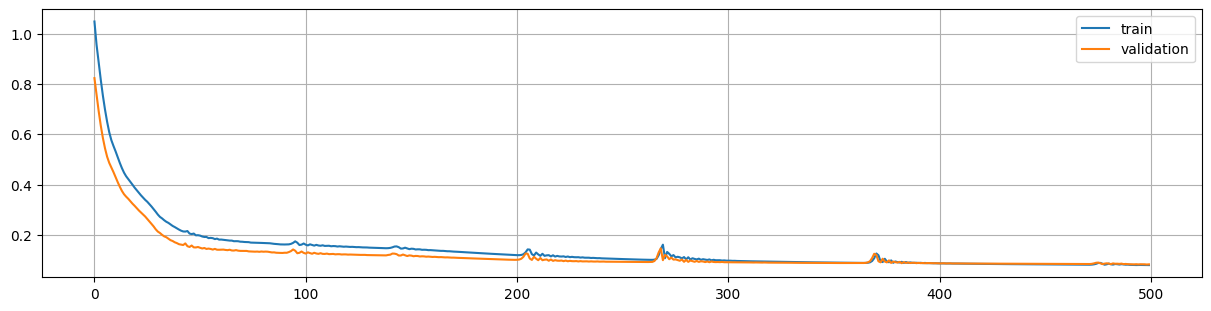

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [59]:
reduded_fused_ds, encoder, scaler = reduce_dims_autoencoder(data_train, fused_ds, d=3)

In [60]:
encoder.save('models/climate_encoder.keras')
print("Encoder model saved to 'models/climate_encoder.keras'")


Encoder model saved to 'models/climate_encoder.keras'


In [61]:
joblib.dump(scaler, 'models/climate_scaler.save')

['models/climate_scaler.save']

In [62]:
fused_ds

,sf_winter,sf_spring,sf_summer,sf_autumn,t2m_winter,t2m_spring,t2m_summer,t2m_autumn,max_t2m_winter,min_t2m_winter,...,max_t2m_autumn,min_t2m_autumn,tp_winter,tp_spring,tp_summer,tp_autumn,si10_winter,si10_spring,si10_summer,si10_autumn
0,0.000543,9.374221e-05,0.000000e+00,0.000252,275.38058,280.85350,289.12216,282.33838,279.05300,269.28100,...,288.26400,277.03897,0.002382,0.002673,0.002367,0.002329,4.363920,3.749001,3.265632,3.989708
1,0.000373,5.353987e-05,0.000000e+00,0.000086,277.76690,279.64474,285.79970,282.61697,280.82736,274.99747,...,285.83142,278.93396,0.002368,0.001799,0.002199,0.002299,6.698223,5.637145,4.505512,6.247214
2,0.000091,7.141299e-06,0.000000e+00,0.000025,280.27695,285.18360,294.48642,287.19394,282.21097,277.90420,...,293.65982,281.29745,0.002814,0.002107,0.001530,0.002798,4.340602,4.203139,3.756210,3.952580
3,0.000145,8.653270e-06,3.973643e-09,0.000077,278.43567,284.01340,295.04645,286.51062,281.04977,274.89215,...,294.98453,279.16217,0.001850,0.001886,0.000979,0.001886,2.730258,2.731695,2.505635,2.373221
4,0.000030,9.602970e-08,0.000000e+00,0.000009,283.82187,287.23740,296.06100,290.55576,285.71530,281.67960,...,296.20752,284.66837,0.001241,0.001351,0.000814,0.001738,3.612827,3.455851,2.982532,3.113860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.000721,9.130950e-06,0.000000e+00,0.000205,275.34010,285.27700,295.11640,285.13266,280.27255,269.26083,...,292.95102,276.19742,0.002217,0.002981,0.003048,0.002569,2.196396,2.442959,1.961628,2.048781
1456,0.000071,3.877011e-06,0.000000e+00,0.000007,280.46072,287.52734,297.57416,289.04834,284.04852,278.35855,...,295.59900,282.20355,0.001302,0.001472,0.000720,0.001479,3.898203,3.942312,3.626674,3.419100
1457,0.001457,2.969612e-04,2.333296e-05,0.001028,273.78760,281.64682,290.66537,282.42440,277.58905,268.42105,...,288.56067,276.23215,0.003254,0.004649,0.004708,0.003610,2.040624,1.992223,1.676998,1.732178
1458,0.000410,1.028030e-05,0.000000e+00,0.000157,275.50342,280.57736,289.44720,283.47160,279.94287,269.88834,...,289.56700,276.73834,0.001779,0.001987,0.002504,0.002397,6.196639,5.218393,4.842985,5.667594


In [63]:
reduded_fused_ds

array([[-0.38410285, -0.24298236,  0.06576589],
       [-0.7895956 , -0.01031058, -0.29804832],
       [ 0.02263355, -0.41120088, -0.33751303],
       ...,
       [ 0.37608522, -0.09417181,  0.24047965],
       [-0.7080711 , -0.21969606, -0.05085089],
       [-0.38373837, -0.44304276,  0.27700803]],
      shape=(1460, 3), dtype=float32)

In [64]:
def add_metadata_to_df(df, metadata):
    return pd.concat([metadata, df], axis=1)

In [65]:
# Récupérer les métadonnées
metadata = get_metadata(loaded_datasets['1970-1979'])
n_cities = len(metadata)

# Séparer les embeddings par période
final_ds_autoencoder = {}

for i, period_name in enumerate(period_names):
    # Extraire les embeddings pour cette période
    start_idx = i * n_cities
    end_idx = (i + 1) * n_cities
    
    period_embeddings = reduded_fused_ds[start_idx:end_idx]
    
    # Convertir en DataFrame
    period_df = pd.DataFrame(period_embeddings)
    
    # Ajouter les métadonnées
    final_ds_autoencoder[period_name] = add_metadata_to_df(period_df, metadata)
    
    print(f"Period {period_name}: shape {final_ds_autoencoder[period_name].shape}")

# Vérifier
display(final_ds_autoencoder['1970-1979'].head())
display(final_ds_autoencoder['2010-2020'].head())

Period 1970-1979: shape (292, 6)
Period 1980-1989: shape (292, 6)
Period 1990-1999: shape (292, 6)
Period 2000-2009: shape (292, 6)
Period 2010-2020: shape (292, 6)


,city,latitude,longitude,0,1,2
0,Aachen,50.776642,6.08342,-0.384103,-0.242982,0.065766
1,Aberdeen,57.143688,-2.09814,-0.789596,-0.010311,-0.298048
2,Aix-en-Provence,43.528301,5.44973,0.022634,-0.411201,-0.337513
3,Alcalá de Henares,40.482052,-3.35996,0.123764,-0.618860,-0.000163
4,Alicante,38.345169,-0.48149,0.213373,-0.680974,-0.317866


,city,latitude,longitude,0,1,2
0,Aachen,50.776642,6.08342,-0.232483,-0.332397,-0.019370
1,Aberdeen,57.143688,-2.09814,-0.764649,-0.017623,-0.329430
2,Aix-en-Provence,43.528301,5.44973,0.186989,-0.566109,-0.351627
3,Alcalá de Henares,40.482052,-3.35996,0.287280,-0.719781,-0.072427
4,Alicante,38.345169,-0.48149,0.327049,-0.761578,-0.375076


## Apply encoder to future data

Load future climate data and apply the trained encoder to generate embeddings for future scenarios.

In [66]:
# Load future datasets for different scenarios and periods
future_periods = ['2041-2050']
scenarios = ['ssp126', 'ssp370', 'ssp585']

future_datasets = {}

for period in future_periods:
    for scenario in scenarios:
        key = f"{period}_{scenario}"
        filename = f"datasets/climate_features_{period}_future_{scenario}.csv"
        future_datasets[key] = pd.read_csv(filename).sort_values(by='city').reset_index(drop=True)
        print(f"Loaded {filename} with shape {future_datasets[key].shape}")

Loaded datasets/climate_features_2041-2050_future_ssp126.csv with shape (292, 27)
Loaded datasets/climate_features_2041-2050_future_ssp370.csv with shape (292, 27)
Loaded datasets/climate_features_2041-2050_future_ssp585.csv with shape (292, 27)


In [67]:
# Extract climate features from future datasets
future_climate_data = {}

for key, df in future_datasets.items():
    future_climate_data[key] = get_climate_features(df)
    print(f"{key}: {future_climate_data[key].shape}")

2041-2050_ssp126: (292, 24)
2041-2050_ssp370: (292, 24)
2041-2050_ssp585: (292, 24)


In [68]:
# Align future data columns with historical data columns (reorder to match)
aligned_future_climate_data = {}

for key, climate_data in future_climate_data.items():
    # Reorder columns to match historical data
    aligned_data = climate_data[historical_cols]
    aligned_future_climate_data[key] = aligned_data
    print(f"Aligned {key}: shape {aligned_data.shape}")

print("\n✅ All future datasets aligned to historical column order!")

Aligned 2041-2050_ssp126: shape (292, 24)
Aligned 2041-2050_ssp370: shape (292, 24)
Aligned 2041-2050_ssp585: shape (292, 24)

✅ All future datasets aligned to historical column order!


In [69]:
# Apply the trained encoder to future data
future_embeddings = {}

for key, climate_data in aligned_future_climate_data.items():
    # Scale the data using the same scaler
    scaled_data = scaler.transform(climate_data)
    
    # Apply the encoder
    embeddings = encoder.predict(scaled_data)
    
    future_embeddings[key] = embeddings
    print(f"Generated embeddings for {key}: shape {embeddings.shape}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Generated embeddings for 2041-2050_ssp126: shape (292, 3)
Generated embeddings for 2041-2050_ssp126: shape (292, 3)
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Generated embeddings for 2041-2050_ssp370: shape (292, 3)
Generated embeddings for 2041-2050_ssp370: shape (292, 3)
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Generated embeddings for 2041-2050_ssp585: shape (292, 3)
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Generated embeddings for 2041-2050_ssp585: shape (292, 3)


In [70]:
# Add metadata to future embeddings and create final datasets
future_final_ds = {}

for key, embeddings in future_embeddings.items():
    # Get metadata from the corresponding future dataset
    period_scenario = key.split('_', 1)
    metadata = get_metadata(future_datasets[key])
    
    # Convert embeddings to DataFrame
    embeddings_df = pd.DataFrame(embeddings)
    
    # Add metadata
    future_final_ds[key] = add_metadata_to_df(embeddings_df, metadata)
    print(f"Final dataset for {key}: shape {future_final_ds[key].shape}")

# Display sample
display(future_final_ds['2041-2050_ssp370'].head())

Final dataset for 2041-2050_ssp126: shape (292, 6)
Final dataset for 2041-2050_ssp370: shape (292, 6)
Final dataset for 2041-2050_ssp585: shape (292, 6)


,city,latitude,longitude,0,1,2
0,Aachen,50.776642,6.08342,-0.107460,-0.315242,-0.210167
1,Aberdeen,57.143688,-2.09814,-0.640035,-0.047685,-0.439292
2,Aix-en-Provence,43.528301,5.44973,0.457259,-0.508489,-0.485325
3,Alcalá de Henares,40.482052,-3.35996,0.402719,-0.725928,-0.098240
4,Alicante,38.345169,-0.48149,0.486168,-0.807272,-0.309353


## Save embeddings datasets

Save the historical and future embeddings with metadata to pickle files for use in climate_analogs.ipynb

In [71]:
# Save historical embeddings
joblib.dump(final_ds_autoencoder, 'models/encoder_historical_embeddings.joblib')
print(f"Saved historical embeddings: {len(final_ds_autoencoder)} periods")

# Save future embeddings
joblib.dump(future_final_ds, 'models/encoder_future_embeddings.joblib')
print(f"Saved future embeddings: {len(future_final_ds)} scenarios")

Saved historical embeddings: 5 periods
Saved future embeddings: 3 scenarios
